<a href="https://colab.research.google.com/github/bil-ardhry/fastai_course_22/blob/main/Collaborate_Filtering_Deepdive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Collaborative Filtering**

In [1]:
import pandas as pd
import numpy as np
import torch
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

## Import Data from [Movie Lens](https://grouplens.org/datasets/movielens/)

In [2]:
path = untar_data(URLs.ML_100k)

In [ ]:
# What's going on behind the scenes with untar_data
??untar_data

In [3]:
# The main table is in the file u.data and is tab separated
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user       100000 non-null  int64
 1   movie      100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
ratings.describe()

,user,movie,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08




*   Now, it is important to remember that latent factors are key to building recommender systems - using collaborative filtering.
*   If we knew the degree to which each user preferred characteristics like directors, actors, genres etc. then the exercise would be pretty straight forward.



In [6]:
# Assuming known latent factor fall into a range between -1 and +1, with positive
# numbers indicating stronger preferential matches and the categories are
# Science Fiction, Action and Old Movies

# We can extend this to the Last Skywalker
last_skywalker = np.array([0.98, 0.9, -0.9])

# A user can be represented as
user1 = np.array([0.9, 0.8, -0.6])

In [7]:
# Calculating a match between this combo by  using a dot product
(user1 * last_skywalker).sum().round(2)

2.14

In [8]:
# Representing Casablanca as
casablanca = np.array([-0.99, -0.3, 0.8])

# and the dot product reveals
(user1 * casablanca).sum()

-1.611

## Creating our Data Loaders

In [9]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
# Merging details with the ratings table
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [11]:
# Creating a dataloader
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [ ]:
??CollabDataLoaders

In [12]:
# For Pytorch to be able to process our data loader, we will represent
# our movie and user latent factor tables as simple matrices
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
# We can use 'look up in an index' as a matrix product and we can pull this off
# by replacing our indices with one-hot-encoded vectors likee in the following
# example.
one_hot_3 = one_hot(3, n_users).float()

user_factors.t() @ one_hot_3


tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [ ]:
??one_hot

In [14]:
user_factors[5]

tensor([-1.2018, -1.2946, -1.8869,  1.2259,  0.2970])



1.   Since using the approach above to create a matrix of one hot encoded vectors will be very memory inefficient, we will use PyTorch's special layer which indexes into arrays / vectors with an integer.
2.   Additionally, it has its derivative calculated in a way that is identical to what it would have been if it had done matmul. with a one hot encoded vector.
3.   The above approach results in ***embeddings***.



##**Collaborative Filtering From Scratch**

In [15]:
# One thing to note is that when a module is called, PyTorch will call a method
# in our class called 'forward' which passes any parameters included in that call

class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    return (users * movies).sum(dim=1)


In [16]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [17]:
# Now that we have defined our architecture, created our parameter matrices
# it is now time to create our Learner.
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [18]:
%%time
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:08
1,1.093331,1.109981,00:08
2,0.958258,0.990199,00:07
3,0.814234,0.894916,00:08
4,0.780714,0.882022,00:07


CPU times: user 39.6 s, sys: 1.17 s, total: 40.8 s
Wall time: 44.6 s


In [19]:
# We can rewrite our DotProduct class to force predictions to fall between
# a sigmoid range of 0 and 5.5  - with the upper limit higher than the base
# requirement since it has been shown to improve performance.
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)


In [20]:
??sigmoid_range

In [21]:
model = DotProduct(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:08
1,0.878134,0.918898,00:07
2,0.675850,0.875467,00:08
3,0.483372,0.877939,00:07
4,0.378927,0.881887,00:08


In [22]:
# We also need to account for users who are more positive or negative than others
# and the fact that some movies are considerably better or worse than others -
# which become the biases to complement our weights. The Dot Product instance
# can't encode either of these at the moment. All it requires is a single number
# for each user.
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias  = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    results = (users * movies).sum(dim=1, keepdim=True)
    results += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
    return sigmoid_range(results, *self.y_range)

In [23]:
# Assessing improvement or degradation for our learner
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:09
1,0.846664,0.865633,00:09
2,0.608090,0.865127,00:08
3,0.413482,0.887318,00:12
4,0.286971,0.894876,00:10


### **Enter... Weight Decay**

When we see the model's performance degrade around the halfway point, this is usually a sign of over-fitting. Our regularization technique of choice will be weight decay or L2 regularization.

What L2 regularization consists of is the addition of the sum of all weights, squared, to our loss function. As we compute gradients, it will add a contribution which will drive the weights to be as low as possible.

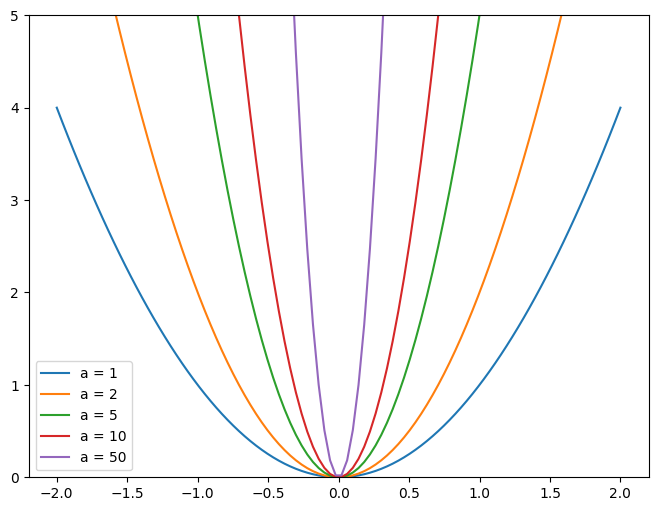

In [25]:
# Here's a demo of how L2 regularization, or WD works
x = np.linspace(-2, 2, 100)
a_s = [1,2,5,10,50]
ys = [a * x**2 for a in a_s]

_, ax = plt.subplots(figsize=(8,6))

for a, y in zip(a_s, ys):
  ax.plot(x, y, label=f'a = {a}')
ax.set_ylim([0, 5])
ax.legend();




*   Allowing a model to learn high parameters may cause it to fit _all_ the data points in the training set with an over complex function, which has sharp changes and may lead to over fitting.
*   Limiting the weights has a trade-off i.e. while it hinders the training of the model - it does yield a state where it can generalize better.
*   WD is a parameter which controls the sum of squares we add to the loss while assuming `parameters` is a tensor of all parameters

`loss_with_wd = loss + wd * (parameters**2).sum()`

*   It would be inefficient, and numerically unstable, to compute such a big sum, while adding it to the loss. *   The derivative of p**2 with respect to p is 2*p hence:

`parameters.grad += wd * 2 * parameters`



In [27]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:09
1,0.888625,0.882614,00:09
2,0.771066,0.832743,00:08
3,0.599807,0.822374,00:08
4,0.504981,0.822528,00:08


**Creating a Custom Embedding Module**

Recreating `DOTProductBias` without the usage of the `Embedding` class. Things we'll need to consider are:


1.   Randomly initialized weight matrix for each embedding.
2.   Optimizers require that they get all the parameters of a module from the module's `parameters` method. This does not happen automatically and we must add a tensor as an attribute to `Module`.



In [28]:
class T(Module):
  def __init__(self):
    self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [29]:
# Now, we need to tell the module that we want to treat a tensor as a parameter.
# So we will have to wrap it in the nn.Parameter class - which acts as a marker
# to show what to include in parameters.

class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [30]:
# Since all PyTorch modules use nn.Parameter for any trainable parameters, that's
# why we haven't had to use it till now.
class T(Module):
  def __init__(self):
    self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [31]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [32]:
# Creating a tensor as a parameter, with random initialization
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [37]:
# Recreating DotProductBias without embedding
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:, 0]]
    movies = self.movie_factors[x[:, 1]]
    result = (users * movies).sum(dim=1)
    result += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
    return sigmoid_range(result, *self.y_range)

In [38]:
# Retraining, all else being equal
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.957051,0.949748,00:09
1,0.847128,0.873611,00:08
2,0.729132,0.839712,00:09
3,0.584509,0.826350,00:09
4,0.482856,0.826882,00:09


**Enterpreting Embeddings and Biases**

In [39]:
# Picking movies with the lowest values in the bias vector to interpret our model's
# results.
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Beautician and the Beast, The (1997)',
 'Mortal Kombat: Annihilation (1997)']

In [40]:
# Here are movies with the highest biases.
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Silence of the Lambs, The (1991)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

Given the range of the interplay between weights and biases, it can be extremely difficult to interpret embedding matrices. So we will use PCA to simplify the readout while pulling the most important directional results.

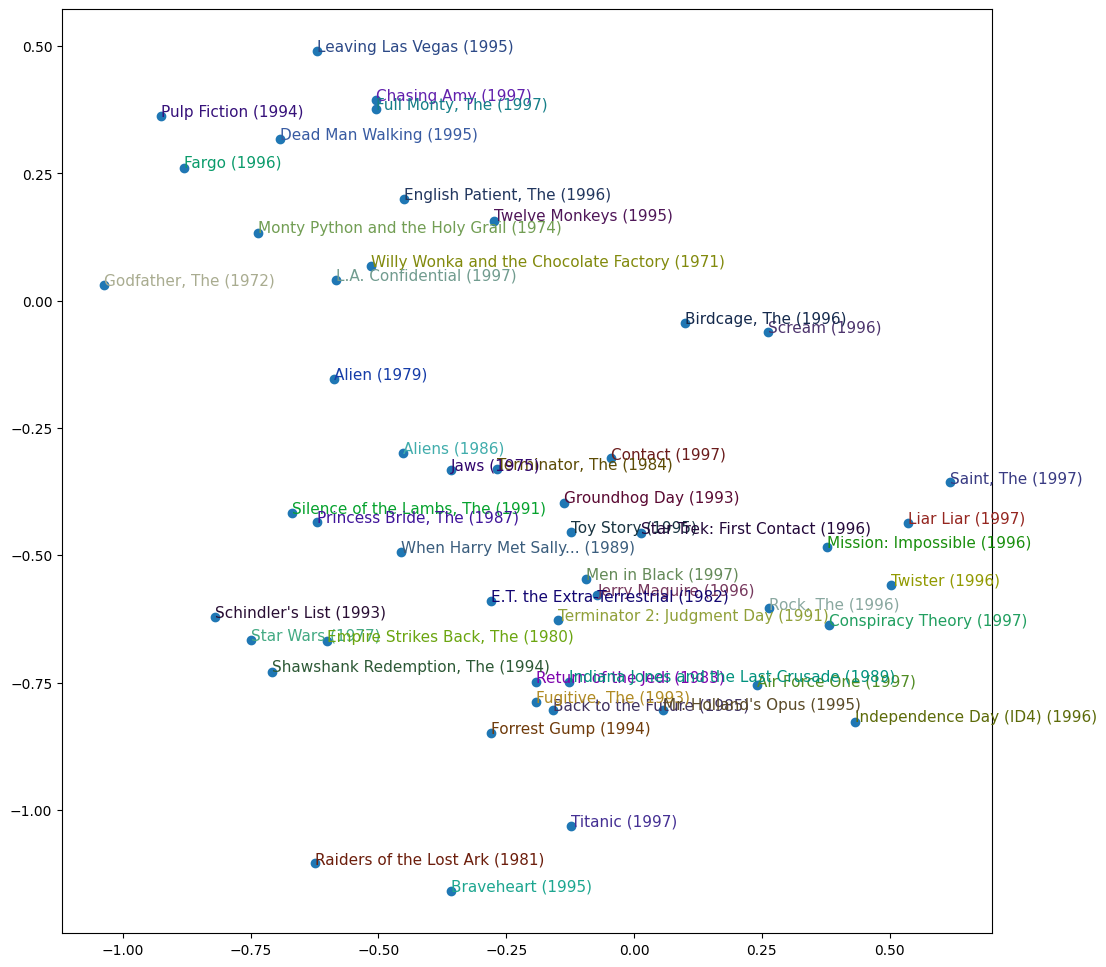

In [45]:
# Visualizing the movies using the two strongest PCA components
g = ratings.groupby('title')['rating'].count()

top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()

idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]

plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### **Recreating Everything Using FastAI.Collab**



In [46]:
# Everything above can be repeated using FastAI
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.927314,0.952735,00:10
1,0.848047,0.875479,00:09
2,0.739689,0.837629,00:09
3,0.587321,0.821143,00:09
4,0.493000,0.822513,00:09


In [47]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [48]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 "Schindler's List (1993)",
 'Silence of the Lambs, The (1991)']

In [49]:
idxs = movie_bias.argsort(descending=False)[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Beautician and the Beast, The (1997)',
 'Crow: City of Angels, The (1996)']